# Práctico 4 - Sesgo y Varianza

## Imports

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm import tqdm

## Seteamos la semilla

In [2]:
# Para obtener resultados reproducibles
np.random.seed(16)

## Función verdadera

El objetivo es aproximar la función $f:[x_{\rm min},x_{\rm max}]\to\mathbb{R}$ que explica la relación entre el atributo $x$ la etiqueta $y$:

$$y = f(x) + \epsilon$$

Donde $\epsilon$ indica ruido en los datos.

Como ejemplo, creamos nuestra $x$ e $y$ sintéticas eligiendo la siguiente formula como relación entre las dos: 

$$y = \frac{x}{2}+\sqrt{\max\{x,0\}}-\cos(x)+2$$

donde ${ x \in \mathbb{R} ∣ -3 < x < 3 }$.

También asumimos un ruido normalmente distribuido, con media = 0 y varianza = 1.

In [3]:
def f(x):
    return .5 * x + np.sqrt(np.max(x, 0)) - np.cos(x) + 2

## Generación de un dataset

### Definición de parámetros

In [4]:
# Tamaño de la muestra
N = 1000

# Error irreducible
sigma_epsilon = 1

# Máximo de x
x_max = 3

# Punto para test
x_test = 2.2

# Vector de valores de x
x = x_max * (2 * np.random.rand(N) - 1)

# Ruido
epsilon = sigma_epsilon * np.random.randn(N)

# Función verdadera + ruido
y = f(x) + epsilon

# Valor de la etiqueta en test
y_test = f(x_test) + sigma_epsilon * np.random.randn()

### Visualización

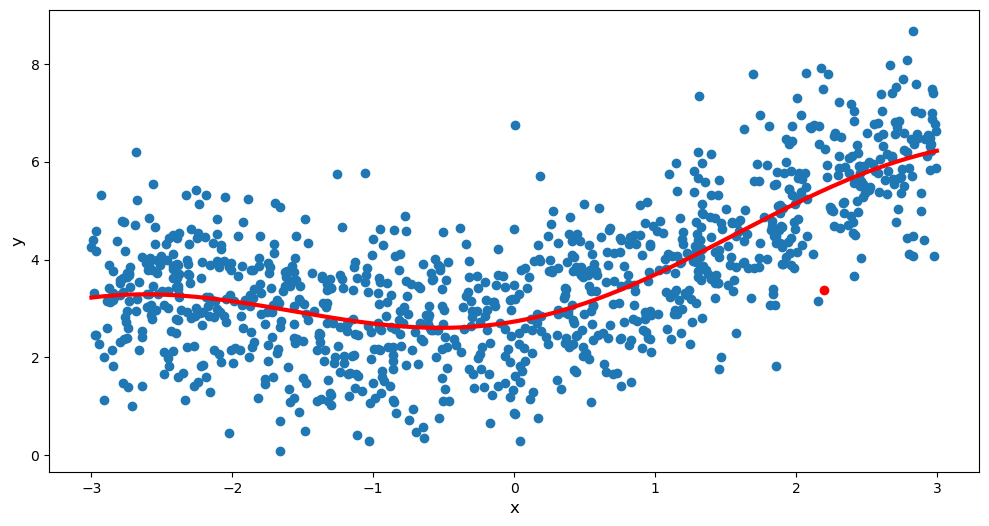

In [5]:
plt.figure(figsize=(12, 6))
x_range = np.linspace(-x_max, x_max, 1000)
plt.scatter(x, y)
plt.plot(x_range, f(x_range), 'r', linewidth=3.0)
plt.scatter(x_test, y_test, c='r')
plt.xlabel('x', size=12)
plt.ylabel('y', size=12)
plt.xticks(np.arange(-x_max, x_max + 1))
plt.show()

## Primera visualización del sesgo y la varianza

In [6]:
# Con power y expand_dims podemos generar polinomios
d=3
np.power(x, np.expand_dims(np.arange(d, -1, -1), 1)).T

array([[-4.57639216e+00,  2.75644177e+00, -1.66025353e+00,
         1.00000000e+00],
       [ 2.68446271e-03,  1.93154539e-02,  1.38980048e-01,
         1.00000000e+00],
       [ 2.81523764e-02,  9.25429572e-02,  3.04208739e-01,
         1.00000000e+00],
       ...,
       [-1.81594471e-05,  6.90878611e-04, -2.62845698e-02,
         1.00000000e+00],
       [ 1.66607824e-01,  3.02782145e-01,  5.50256436e-01,
         1.00000000e+00],
       [ 3.57077655e+00,  2.33619155e+00,  1.52846052e+00,
         1.00000000e+00]])

In [7]:
# Definimos nuestra hipótesis polinomial
def h(x, w):
    d = len(w) - 1
    return np.sum(w * np.power(x, np.expand_dims(np.arange(d, -1, -1), 1)).T, 1)

In [8]:
# Vamos a generar varias hipótesis polinomiales con una fracción de los datos
n = int(.02 * N)

# Fijamos un punto de test
x_test = 2.2

# Definimos el rango de valores de x
x_range = np.linspace(-x_max, x_max, 1000)

# Definimos colores para la visualización
colors = np.array(['tab:green', 'tab:purple', 'tab:cyan', 'tab:orange'])

# Definimos los grados de los polinomios
d_arr = [1, 2, 3, 5]

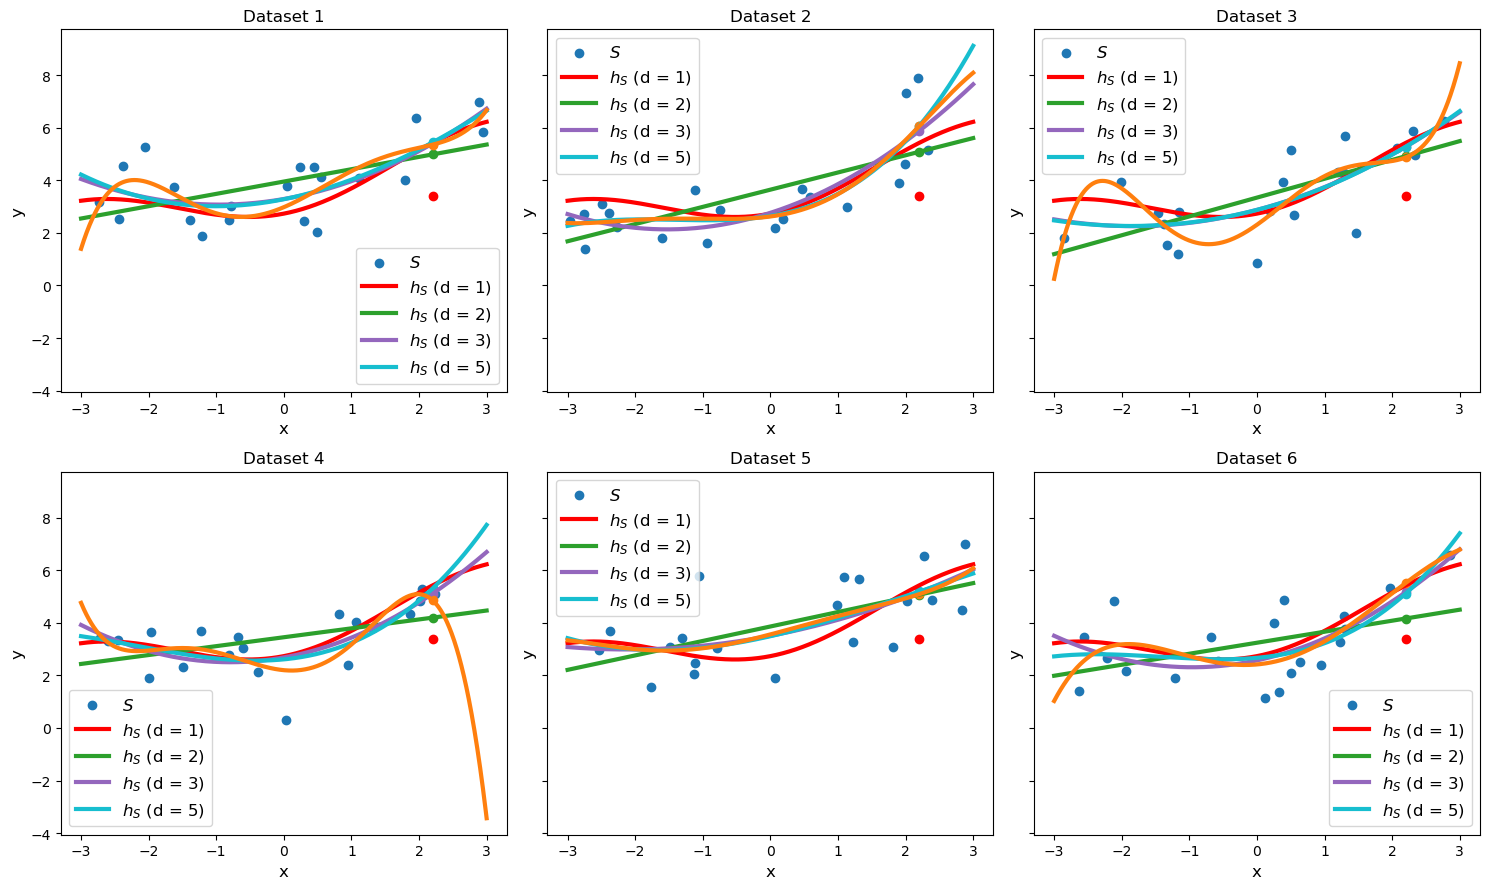

In [9]:
# Ajustamos y graficamos los polinomios al mismo tiempo
# Como ejemplo, mostramos que Numpy puede ajustar polinomios

# El objetivo es visualizar la dependencia de la hipótesis con el dataset

# Contador para el dataset
cnt = 1

# Creamos la figura
fig, axs = plt.subplots(2, 3, sharey=True, figsize=(15, 9))

# Para cada subplot graficamos los ajustes
for i in range(2):
    for j in range(3):
        # Tomamos una muestra de x de tamaño n
        idx = np.random.permutation(N)[:n]
        x_train, y_train = x[idx], y[idx]
        
        # Ajustamos los coeficientes para cada grado
        w = []
        for d in d_arr:
            w.append(np.polyfit(x_train, y_train, d))
        
        # Graficamos el dataset 
        axs[i, j].scatter(x_train, y_train)
        
        # Graficamos la función verdadera
        axs[i, j].plot(x_range, f(x_range), 'r', linewidth=3.0)
        
        # Graficamos las hipótesis (los polinomios) para este dataset
        for k in range(len(w)):
            axs[i, j].plot(x_range, h(x_range, w[k]), colors[k], linewidth=3.0)
        
        # Agregamos el punto de testeo
        axs[i, j].scatter(x_test, y_test, c='r')
        
        # Agregamos las predicciones para el punto de testeo
        for k in range(len(w)):
            axs[i, j].scatter(x_test, h(x_test, w[k]), c=colors[k])
        
        # Labels y leyenda
        axs[i, j].set_xlabel('x', size=12)
        axs[i, j].set_ylabel('y', size=12)
        axs[i, j].legend([r'$S$', r'$h_S$ (d = 1)', r'$h_S$ (d = 2)', 
                          r'$h_S$ (d = 3)', r'$h_S$ (d = 5)'], fontsize=12)
        axs[i, j].title.set_text('Dataset {}'.format(cnt))
        cnt += 1
plt.tight_layout()
plt.show()

## Segunda visualización del sesgo y la varianza

100%|██████████| 10000/10000 [00:04<00:00, 2438.01it/s]


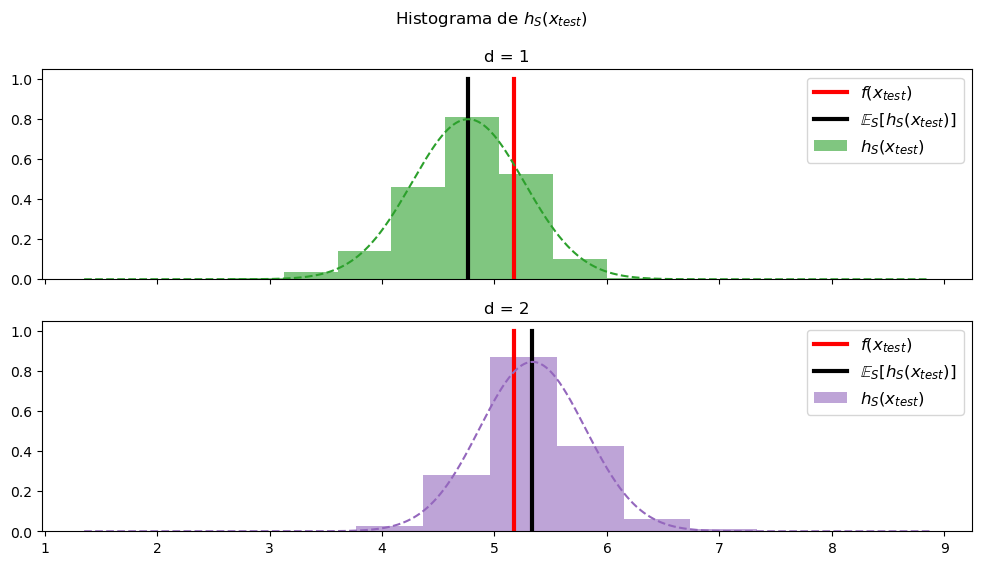

In [10]:
# Repetimos lo anterior con R datasets
R = 10000

# Grados de los polinomios
d_arr = [1, 2, 3, 5]

# Calculamos las R predicciones en x_test
y_hat_test = np.zeros((len(d_arr), R))

# Iteramos en los R datasets
for r in tqdm(range(R)):
    # Tomamos una muestra de tamaño n
    n = int(.02 * N)
    idx = np.random.permutation(N)[:n]
    x_train, y_train = x[idx], y[idx]
    
    # Calculamos la predicción para cada grado
    for k in range(len(d_arr)):
        d = d_arr[k]
        w = np.polyfit(x_train, y_train, d)
        y_hat_test[k, r] = h(x_test, w)

# Calculamos la predicción promedio y su desvío
y_hat_test_mean = np.mean(y_hat_test, 1)
y_hat_test_std = np.std(y_hat_test, 1)

# Graficamos los resultados en un histograma
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(12, 6))

for k in range(2):
    axs[k].hist(y_hat_test[k], density=True, color=colors[k], alpha=0.6)             
    xlim = axs[k].get_xlim()
    axs[k].plot([f(x_test), f(x_test)], [0, 1], 'r', linewidth=3.0)
    axs[k].plot([y_hat_test_mean[k], y_hat_test_mean[k]], [0, 1], c='k', linewidth=3.0)
    axs[k].title.set_text('d = {}'.format(d_arr[k]))
    axs[k].legend([r'$f(x_{test})$', r'$\mathbb{E}_S[h_S(x_{test})]$', r'$h_S(x_{test})$'], fontsize=12)
    
for k in range(2):
    x_range = np.linspace(xlim[0], xlim[1], 1000)
    axs[k].plot(x_range, stats.norm.pdf(x_range, y_hat_test_mean[k], y_hat_test_std[k]), color=colors[k], ls='--')
    
plt.suptitle(r'Histograma de $h_S(x_{test})$', size=12)
plt.show()

## Descomposición del error en sesgo y varianza

In [11]:
# Cantidad de datasets
R = 10000

# Tamaño de las muestras
n = int(.02 * N)

# Tamaño del conjunto de test
n_test = 1000

# Grados de los polinomios
d_arr = np.arange(5)

In [12]:
# Creamos el dataset de test

# Sorteamos los valores de x
x_test = x_max + np.random.rand(n_test) - .5  # shape: (n_test,)

# Sorteamos el ruido
epsilon = sigma_epsilon * np.random.randn(n_test)  # shape: (n_test,)

# Calculamos las etiquetas
y_test = f(x_test) + epsilon  # shape: (n_test,)

In [13]:
# Calculamos las predicciones y error para cada dataset
train_squared_error = np.zeros((len(d_arr), R))  # shape: (len(d_arr), R)
y_hat_test = np.zeros((len(d_arr), R, n_test))  # shape: (len(d_arr), R, n_test)

# Iteramos en los datasets
for r in tqdm(range(R)):
    # Creamos el dataset
    idx = np.random.permutation(N)[:n]
    x_train, y_train = x[idx], y[idx]  # shape: (n,), (n,)
    
    # Entrenamos para cada uno de los grados
    for k in range(len(d_arr)):
        d = d_arr[k]
        w = np.polyfit(x_train, y_train, d)
        train_squared_error[k, r] = np.mean((y_train - h(x_train, w)) ** 2)  # train MSE for a specific realization
        y_hat_test[k, r, :] = h(x_test, w)  # test set predictions for a specific realization

# Calculamos error, sesgo y varianza
test_squared_error = np.mean((y_hat_test - y_test) ** 2, 1)  # shape: (len(d_arr), n_test)
bias_squared = (np.mean(y_hat_test, 1) - f(x_test)) ** 2  # shape: (len(d_arr), n_test)
var_y_hat_test = np.var(y_hat_test, 1)  # shape: (len(d_arr), n_test)

100%|██████████| 10000/10000 [00:11<00:00, 887.36it/s]


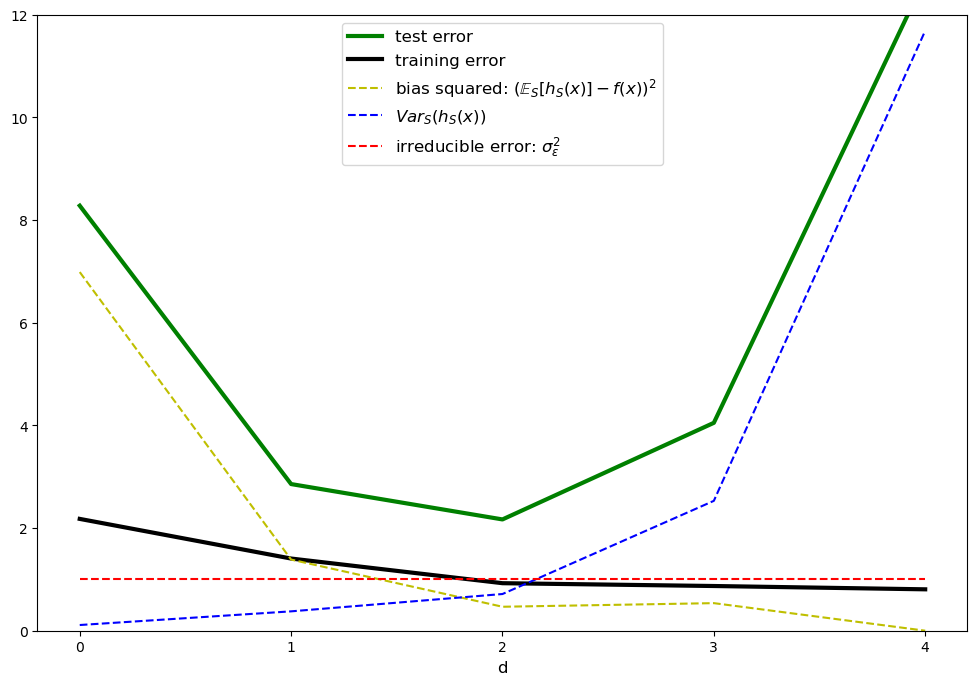

In [14]:
# Graficamos los resultados
plt.figure(figsize=(12, 8))
plt.plot(d_arr, np.mean(test_squared_error, 1), 'g', linewidth=3.0)  # np.mean(test_squared_error, 1) shape: (len(d_arr),)
plt.plot(d_arr, np.mean(train_squared_error, 1), 'k', linewidth=3.0)  # np.mean(train_squared_error, 1) shape: (len(d_arr),)
plt.plot(d_arr, np.mean(bias_squared, 1), 'y--')  # np.mean(bias_squared, 1) shape: (len(d_arr),)
plt.plot(d_arr, np.mean(var_y_hat_test, 1), 'b--')  # np.mean(var_y_hat_test, 1) shape: (len(d_arr),)
plt.plot(d_arr, (sigma_epsilon ** 2) * np.ones_like(d_arr), 'r--')
# plt.plot(d_arr, np.mean(bias_squared + var_y_hat_test + sigma_epsilon ** 2, 1), 'm--')
plt.xticks(d_arr)
plt.xlabel('d', size=12)
plt.legend(['test error', 'training error', r'bias squared: $(\mathbb{E}_S[h_S(x)] - f(x))^2$',
            r'$Var_S(h_S(x))$', r'irreducible error: $\sigma_\epsilon^2$'], loc='upper center', fontsize=12)
plt.ylim([0, 12])
plt.show()